In [1]:
#Importing fastai will also import numpy, pytorch, etc. 
from fastai.vision import *
from numbers import Integral
import seaborn as sns
from sklearn.datasets import make_moons, make_blobs, make_circles, make_classification
import pdb
import contextlib
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [2]:
#Modified from 
K=2
class MultiTransformLabelList(LabelList):
    def __getitem__(self,idxs:Union[int,np.ndarray])->'LabelList':
        "return a single (x, y) if `idxs` is an integer or a new `LabelList` object if `idxs` is a range."
        idxs = try_int(idxs)
        if isinstance(idxs, Integral):
            if self.item is None: x,y = self.x[idxs],self.y[idxs]
            else:                 x,y = self.item   ,0
            if self.tfms or self.tfmargs:
                #I've changed this line to return a list of augmented images
                x = [x.apply_tfms(self.tfms, **self.tfmargs) for _ in range(K)]
            if hasattr(self, 'tfms_y') and self.tfm_y and self.item is None:
                y = y.apply_tfms(self.tfms_y, **{**self.tfmargs_y, 'do_resolve':False})
            if y is None: y=0
            return x,y
        else: return self.new(self.x[idxs], self.y[idxs])
        
#I'll also need to change the default collate function to accomodate multiple augments
def MixmatchCollate(batch):
    batch = to_data(batch)
    if isinstance(batch[0][0],list):
        batch = [[torch.stack(s[0]),s[1]] for s in batch]
    return torch.utils.data.dataloader.default_collate(batch)


In [3]:
#Grab file path to cifar dataset. Will download data if not present
path = untar_data(URLs.CIFAR)

#Custom ImageList with filter function
class MixMatchImageList(ImageList):
    def filter_train(self,num_items,seed=2343):
        train_idxs = np.array([i for i,o in enumerate(self.items) if Path(o).parts[-3] != "test"])
        valid_idxs = np.array([i for i,o in enumerate(self.items) if Path(o).parts[-3] == "test"])
        np.random.seed(seed)
        keep_idxs = np.random.choice(train_idxs,num_items,replace=False)
        self.items = np.array([o for i,o in enumerate(self.items) if i in np.concatenate([keep_idxs,valid_idxs])])
        return self
    
#Create two databunch objects for the labeled and unlabled images. A fastai databunch is a container for train, validation, and
#test dataloaders which automatically processes transforms and puts the data on the gpu.
data_labeled = (MixMatchImageList.from_folder(path)
                .filter_train(4000) #Use 500 labeled images for traning
                .split_by_folder(valid="test") #test on all 10000 images in test set
                .label_from_folder()
                .transform(get_transforms(),size=32)
                #On windows, must set num_workers=0. Otherwise, remove the argument for a potential performance improvement
                .databunch(bs=64,num_workers=0)
                .normalize(cifar_stats))



train_set = set(data_labeled.train_ds.x.items)
src = (ImageList.from_folder(path)
        .filter_by_func(lambda x: x not in train_set)
        .split_by_folder(valid="test"))
src.train._label_list = MultiTransformLabelList
data_unlabeled = (src.label_from_folder()
         .transform(get_transforms(),size=32)
         .databunch(bs=128,collate_fn=MixmatchCollate,num_workers=0)
         .normalize(cifar_stats))

#Databunch with all 50k images labeled, for baseline
data_full = (ImageList.from_folder(path)
        .split_by_folder(valid="test")
        .label_from_folder()
        .transform(get_transforms(),size=32)
        .databunch(bs=128,num_workers=0)
        .normalize(cifar_stats))

In [4]:
def mixup(a_x,a_y,b_x,b_y,alpha=0.75):
    l = np.random.beta(alpha,alpha)
    l = max(l,1-l)
    x = l * a_x + (1-l) * b_x
    y = l* a_y + (1-l) * b_y
    return x,y

In [5]:

def sharpen(p,T=0.5):
    u = p ** (1/T)
    return u / u.sum(dim=1,keepdim=True)

In [6]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1   = nn.Linear(16*5*5, 120)
        self.fc2   = nn.Linear(120, 84)
        self.fc3   = nn.Linear(84, 10)

    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = F.max_pool2d(out, 2)
        out = F.relu(self.conv2(out))
        out = F.max_pool2d(out, 2)
        out = out.view(out.size(0), -1)
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out

In [7]:

class EntropyMinTrainer(LearnerCallback):
    def __init__(self, learn, T=0.5):
        super().__init__(learn)
        self.T = T
        
    def on_train_begin(self, **kwargs):
        self.l_dl = iter(data_labeled.train_dl)
        self.it = 0
        
    def on_batch_begin(self, train, last_input, **kwargs):
        if not train: return 
        with torch.no_grad():
            ul_labels = sharpen(torch.softmax(self.learn.model(last_input),dim=1),T=self.T)
            #ul_labels = torch.softmax(self.learn.model(*last_input),dim=1)
        
        self.it += 1
        ramp = self.it / 800.0 if self.it < 800 else 1.0
        return {"last_target": (ul_labels,ramp)}
    
    def on_backward_begin(self, last_loss, last_output, **kwargs):
        try:
            l_x,l_y = next(self.l_dl)
        except:
            self.l_dl = iter(data_labeled.train_dl)
            l_x,l_y = next(self.l_dl)
            
        real_preds = self.learn.model(l_x)
        real_loss = F.cross_entropy(real_preds,l_y)
        return {"last_loss": last_loss + real_loss}
    
def entropy_min_loss(preds,target,ramp=None):
    if ramp is None:
        return F.cross_entropy(preds,target)
    preds = torch.softmax(preds,dim=1)
    return 10.0 * ramp * F.mse_loss(preds,target)
    #p = torch.softmax(preds,dim=1)
    #return -(p * torch.log(p)).sum(dim=1).mean()
    #d = torch.distributions.Categorical(torch.softmax(preds,dim=1))
    #return d.entropy().mean()


In [8]:
#model1= EfficientNetB0()
model = LeNet()

In [9]:
learnEn1 = Learner(data_full,model,loss_func=entropy_min_loss,callback_fns=[EntropyMinTrainer],metrics=accuracy)


In [10]:

learnEn1.fit_one_cycle(2,3e-3,wd=1e-4)


epoch,train_loss,valid_loss,accuracy,time
0,0.023606,1.619096,0.426500,02:18
1,0.047741,1.449251,0.502200,02:18


In [11]:
learnEn1.validate()

[1.4492507, tensor(0.5022)]

In [12]:
class MixupLoss(nn.Module):
    def forward(self, preds, target, unsort=None, ramp=None, bs=None):
        if unsort is None:
            return F.cross_entropy(preds,target)
        preds = preds[unsort]
        preds_l = preds[:bs]
        preds_ul = preds[bs:]
        preds_l = torch.log_softmax(preds_l,dim=1)
        preds_ul = torch.softmax(preds_ul,dim=1)
        loss_x = -(preds_l * target[:bs]).sum(dim=1).mean()
        loss_u = F.mse_loss(preds_ul,target[bs:])
        self.loss_x = loss_x.item()
        self.loss_u = loss_u.item()
        return loss_x + 100 * ramp * loss_u

In [13]:
class MixMatchTrainer(LearnerCallback):
    _order=-20
    def on_train_begin(self, **kwargs):
        self.l_dl = iter(data_labeled.train_dl)
        self.smoothL, self.smoothUL = SmoothenValue(0.98), SmoothenValue(0.98)
        self.recorder.add_metric_names(["l_loss","ul_loss"])
        self.it = 0
        
    def on_batch_begin(self, train, last_input, last_target, **kwargs):
        if not train: return
        try:
            x_l,y_l = next(self.l_dl)
        except:
            self.l_dl = iter(data_labeled.train_dl)
            x_l,y_l = next(self.l_dl)
            
        x_ul = last_input
        
        with torch.no_grad():
            ul_labels = sharpen(torch.softmax(torch.stack([self.learn.model(x_ul[:,i]) for i in range(x_ul.shape[1])],dim=1),dim=2).mean(dim=1))
            
        x_ul = torch.cat([x for x in x_ul])
        ul_labels = torch.cat([y.unsqueeze(0).expand(K,-1) for y in ul_labels])
        
        l_labels = torch.eye(data_labeled.c).cuda()[y_l]
        
        w_x = torch.cat([x_l,x_ul])
        w_y = torch.cat([l_labels,ul_labels])
        idxs = torch.randperm(w_x.shape[0])
        
        mixed_input, mixed_target = mixup(w_x,w_y,w_x[idxs],w_y[idxs])
        bn_idxs = torch.randperm(mixed_input.shape[0])
        unsort = [0] * len(bn_idxs)
        for i,j in enumerate(bn_idxs): unsort[j] = i
        mixed_input = mixed_input[bn_idxs]
    

        ramp = self.it / 3000.0 if self.it < 3000 else 1.0
        return {"last_input": mixed_input, "last_target": (mixed_target,unsort,ramp,x_l.shape[0])}
    
    def on_batch_end(self, train, **kwargs):
        if not train: return
        self.smoothL.add_value(self.learn.loss_func.loss_x)
        self.smoothUL.add_value(self.learn.loss_func.loss_u)
        self.it += 1

    def on_epoch_end(self, last_metrics, **kwargs):
        return add_metrics(last_metrics,[self.smoothL.smooth,self.smoothUL.smooth])


In [14]:

learn1 = Learner(data_unlabeled,model,loss_func=MixupLoss(),callback_fns=[MixMatchTrainer],metrics=accuracy)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


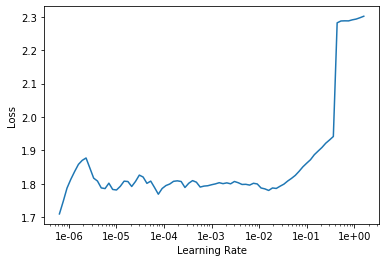

In [15]:

## Finidng Ideal learning late
learn1.lr_find()
learn1.recorder.plot()

In [16]:
learn1.fit_one_cycle(5,1e-4,wd=0.02)


epoch,train_loss,valid_loss,accuracy,l_loss,ul_loss,time
0,1.817637,1.455041,0.492200,1.708369,0.010646,02:56
1,1.990398,1.549699,0.463100,1.744873,0.011011,02:49
2,2.054816,1.537553,0.475500,1.694877,0.010519,02:54
3,2.231636,1.635129,0.445100,1.728713,0.010876,02:54
4,2.403152,1.698650,0.427800,1.775471,0.010791,02:51


In [17]:
learn1.validate()

[1.6986498, tensor(0.4278)]